In [ ]:
# from torchvision import datasets
# from torchvision import transforms
# mnist_trainset = datasets.MNIST(root="./data/", train=True, transform = transforms.ToTensor(), download=True)
# mnist_testset = datasets.MNIST(root="./data/", train=False, transform = transforms.ToTensor(), download=False)

In [37]:
import numpy as np

from model import Model
from rbm import RBM
from dbn import DBN

def calcul_softmax(rbm:RBM, entree):
    # sortie = rbm.entree_sortie(entree)
    sortie = entree@rbm.W + rbm.b
    exp_sortie = np.exp(sortie - np.max(sortie, axis=1, keepdims=True))
    return exp_sortie / np.sum(exp_sortie, axis=1, keepdims=True)

def to_one_hot(arr, class_count):
    n = len(arr)
    result = np.zeros((n, class_count))
    for i in range(n):
        result[i, arr[i]] = 1
    return result

def get_predictions(arr):
    return np.argmax(arr, axis=1)

def bce_loss(y_truth, y_pred):
    return -(y_truth*np.log(y_pred) + (1-y_truth)*np.log(1-y_pred))

def activation_derivative(x):
    return -np.exp(x) / (1+np.exp(x)) # note the + sign because of our definition of the rbm

class DNN():
    def __init__(self, sizes):
        assert len(sizes) >= 2, "Need to specify at least input and output sizes"
        self.net = DBN(sizes)

    def pretrain(self, X, nb_epoch, batch_size, lr):
        self.net.train(X, nb_epoch, batch_size, lr)

    def entree_sortie_reseau(self, X):
        sorties = [X]
        for iLayer in range(len(self.net.rbm_layers)-1):
            layer = self.net.rbm_layers[iLayer]
            sorties.append(layer.entree_sortie(sorties[iLayer]))
        last_layer = self.net.rbm_layers[-1]
        sorties.append(sorties[-1]@last_layer.W + last_layer.b)
        return sorties, calcul_softmax(last_layer, sorties[-2])
    
    def retropropagation(self, X, labels, nb_epoch, batch_size, lr, verbose_interval = 10, debug=False):
        n = X.shape[0]
        layer_count = len(self.net.rbm_layers)  # note that the last layer is the prediction layer
        y = to_one_hot(labels, self.net.rbm_layers[-1].W.shape[1])
        prev_loss = 1e10
        for ep in range(nb_epoch):
            # print(f"=========ep {ep}========")
            ep_loss = 0
            indexes = np.array(range(n))
            np.random.shuffle(indexes)
            for j in range(0, n, batch_size):
                batch_ids = indexes[j:min(j+batch_size, n)]
                l = batch_ids.shape[0]
                batch_y = y[batch_ids, :]
                batch_X = X[batch_ids, :]
                sorties, y_pred = self.entree_sortie_reseau(batch_X)
                loss = bce_loss(batch_y, y_pred)
                dA = 0 # define dA but not use it yet

                if debug:
                    print("prediction",y_pred[:2,:])
                    print("GT",batch_y[:2,:])

                # other layers
                for iLayer in range(layer_count-1, -1, -1):
                    x = sorties[iLayer]
                    curr_layer = self.net.rbm_layers[iLayer]
                    if iLayer == layer_count - 1: # softmax
                        dZ = y_pred - batch_y
                    else: # sigmoid(-entree@W - b)
                        dZ = dA * activation_derivative(x@curr_layer.W + curr_layer.b)
                    dW = 1/l * x.T @ dZ
                    db = 1/l * np.sum(dZ, axis=0)
                    dA = dZ @ curr_layer.W.T
                    
                    # print(dZ, dW, db, dA)

                    # gradients
                    curr_layer.b -= lr * db
                    curr_layer.W -= lr * dW

                    if debug and ep in [0,1] and iLayer == layer_count-2: # just debug
                        print("dloss/dZ", dZ)
                        print("b",curr_layer.b)
                        print("dloss/db", db)

                ep_loss += np.sum(loss)

            # if abs(ep_loss - prev_loss) < 1e-10: 
                # print(f"same at ep {ep}")
                # print(batch_y, y_pred)
            prev_loss = ep_loss
            if verbose_interval and (ep+1) % verbose_interval == 0:
                print("Loss at episode %s: %f" % (ep+1, ep_loss))

    def test(self, X, y):
        _, y_pred_softmax = self.entree_sortie_reseau(X)
        y_pred = get_predictions(y_pred_softmax)
        taux_erreur = np.sum(y_pred != y) / y_pred.shape[0]
        print("Taux d'erreur :", taux_erreur.item())

In [38]:
np.set_printoptions(threshold=np.inf)

In [39]:
# testing with alphadigits first because the dataset is already sorted
import scipy

data = scipy.io.loadmat('data/binaryalphadigs.mat')
images_raw = data['dat']

label_list = list(range(10)) #list(range(36))
label_count = len(label_list)
TRAIN_SIZE = 26
TEST_SIZE = 13
train_ids = list(range(TRAIN_SIZE))
test_ids = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))

X_train = np.zeros((label_count*TRAIN_SIZE,20*16))
X_test = np.zeros((label_count*TEST_SIZE,20*16))

y_train = np.zeros(label_count*TRAIN_SIZE, dtype=int) 
y_test = np.zeros(label_count*TEST_SIZE, dtype=int)

for i in range(1,label_count):
    y_train[i*TRAIN_SIZE:i*(TRAIN_SIZE+1)] = label_list[i]
    y_test[i*TEST_SIZE:i*(TEST_SIZE+1)] = label_list[i]

for char_type in label_list:
    char_images = images_raw[char_type]
    for i in range(TRAIN_SIZE + TEST_SIZE):
        if i < TRAIN_SIZE: 
            ref = X_train
            mult = TRAIN_SIZE
            ind = i
        else: 
            ref = X_test
            mult = TEST_SIZE
            ind = i - TRAIN_SIZE
        img_raw = char_images[i]
        for j, line in enumerate(img_raw):
            ref[char_type*mult + ind, j*len(char_images[0][0]):(j+1)*len(char_images[0][0])] = line

In [41]:
dnn = DNN([20*16, 256, 100, label_count])# DNN([20*16, 16*9*7, 32*4*3, 64*2*1, 36]) # reminiscent of a CNN

# dnn.pretrain(X_train, 100, 64, 0.1)
dnn.test(X_test, y_test)

Taux d'erreur : 0.34615384615384615


In [43]:
dnn.retropropagation(X_train, y_train, 1000, 128, 0.1, verbose_interval=100, debug=False)
dnn.test(X_test, y_test)

Loss at episode 100: 309.314530
Loss at episode 200: 254.103482
Loss at episode 300: 191.955506
Loss at episode 400: 197.594193
Loss at episode 500: 373.485773
Loss at episode 600: 306.339093
Loss at episode 700: 291.680894
Loss at episode 800: 270.847061
Loss at episode 900: 256.574705
Loss at episode 1000: 246.440517
Taux d'erreur : 0.34615384615384615


In [11]:
for layer in dnn.net.rbm_layers:
    print("W", layer.W)
    print("b",layer.b)

W [[ 7.17298054e-03  6.21898729e-03  1.19515271e-02 -1.74203333e-02
   7.91483255e-03  1.38225062e-02 -1.83535277e-03  8.10742776e-03
  -4.87589891e-03 -4.61152357e-03 -3.14887749e-03 -1.43944300e-02
   1.41980882e-03  1.94029017e-03 -2.96012479e-03  1.15840178e-02
   1.11169660e-02  2.26496251e-03 -3.54566575e-03  7.29320366e-03
   2.56085491e-03  1.49111595e-02 -9.50698304e-03  6.42638701e-04
   1.35195377e-02 -1.53076243e-02  2.37427241e-02  5.08551383e-03
   1.31735316e-03  2.54573532e-03 -1.72396956e-03  5.21944947e-03
  -1.53131141e-03  2.78093744e-03 -8.17379854e-03  1.50815061e-03
  -7.03263924e-03  4.81154710e-03 -1.89040630e-02 -1.69522299e-02
   2.74492838e-03 -5.79889760e-03 -1.26481613e-02  5.45146394e-03
  -8.20345530e-03  3.83458645e-03 -4.69172339e-03 -4.45997406e-03
  -3.25242452e-03 -1.84964316e-02 -6.71562997e-03  1.74558472e-02
  -5.07945456e-03  2.00412110e-03  6.76686164e-03 -8.17547240e-03
  -1.21634095e-02 -4.78294289e-03 -6.66930320e-03 -1.90933283e-04
  -1.160

In [14]:
def preprocess_mnist(img):
    res = img[0][0].numpy().flatten()
    res = (res > 0.5).astype(int)
    return res


def get_X_y(dataset, n = None):
    n = len(dataset)
    imgs = np.zeros((n , 28*28))
    labels = np.zeros(n)
    for i in range(n):
        img, label = dataset[i]
        imgs[i,:] = preprocess_mnist(img)
        labels[i] = label
    return imgs, labels

In [ ]:
_ , probs = dnn.entree_sortie_reseau(mnist_testset[0][0])
print("True label: {mnist_testset[0][1]}\nProbs:", probs)

d:\cours\ENSTA\P3\deep learning 2\deep-learning-2\rbm.py:5: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


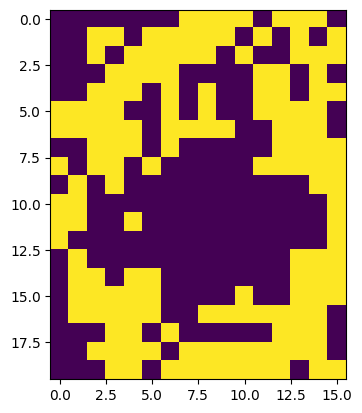

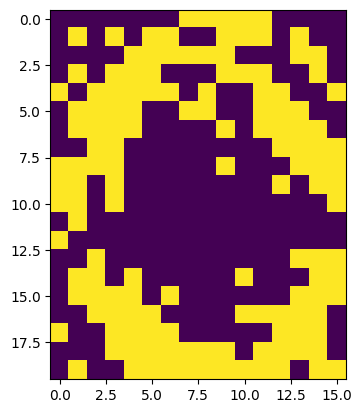

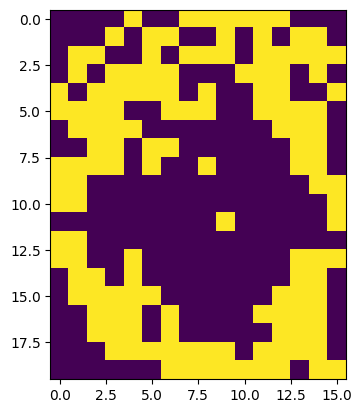

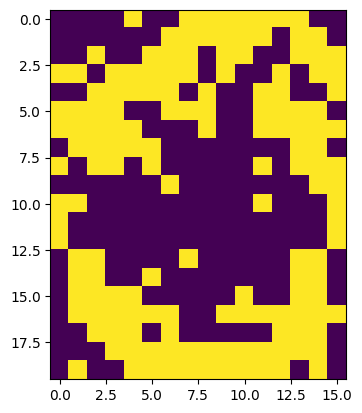

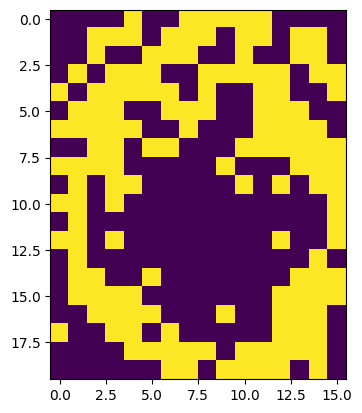

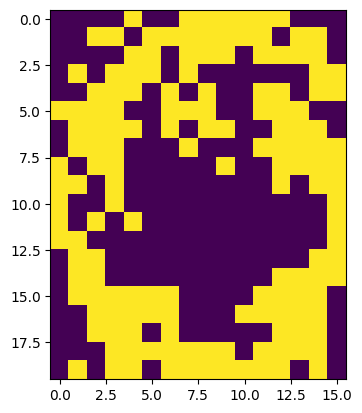

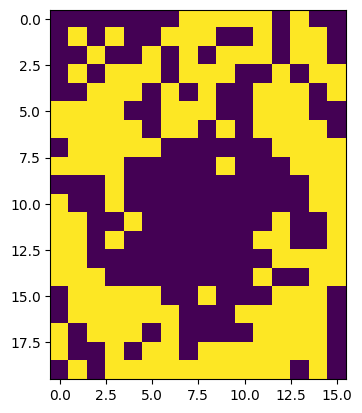

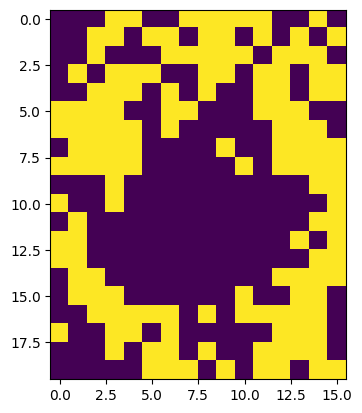

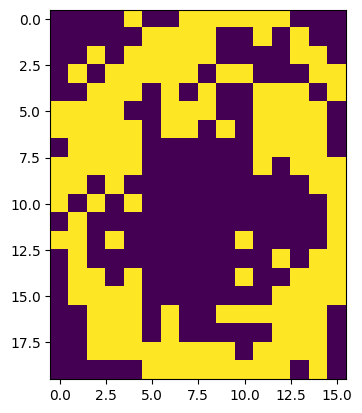

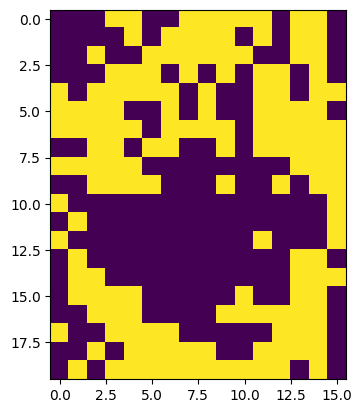

In [7]:
from rbm import RBM
from eval_model import evaluate

dataLoader = lambda: lire_alpha_digit(0)

evaluate(RBM, dataLoader, 1000, p=20*16, q=500)

In [ ]:
dnn = DNN([])